# Accelerator / Deflector Demo

In this notebook we will optimize a laser-driven electron deflecting structure.

In this problem, we'll have an electron flowing in the y direction through the center of our domain.

We have a laser source coming in from the left which we will use to deflect the electron in the out of plane direction.

We'll optimize the regions around the electron trajectory to maximize this deflection, while leaving a central gap for the electron to flow through.

In [1]:
#
#                ______  e-   ______
#                ||||||   ^   ||||||        
# driving laser  ||||||   |   ||||||        
# -------------> ||||||   |   ||||||        
#                ||||||   |   ||||||   
#                ||||||   |   ||||||        
#                ------       ------
#                design       design
#                region       region
#

In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp
import sys
sys.path.append('..')

from angler import Optimization, Simulation
from angler.structures import accelerator

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# fundamental constants and simulation parameters
c0 = 3e8                     # speed of light in vacuum (m/s)
lambda_m = 2e-6              # waveength in meters
omega = 2*np.pi*c0/lambda_m  # angular frequency (2pi/s)
dl = 0.5e-1                  # grid size (microns)
NPML = [15, 0]               # number of pml grid points on x and y borders
pol = 'Hz'                   # polarization (either 'Hz' or 'Ez')
num_cells = 5                # number of cells to tile in plots

In [4]:
# material constants
n_index = np.sqrt(2)               # refractive index
eps_m = n_index**2           # relative permittivity

In [5]:
# geometric parameters
beta = 0.5                  # electron speed / speed of light
gap = 0.4                   # gap size (microns)
lambda0 = lambda_m*1e6      # free space wavelength (microns)
L = 5                       # width of design region (microns)
spc = 2                     # space between PML -> Src. & Src -> Design region

Computed a domain with 397 grids in x and 20 grids in y
The simulation has 40 grids per free space wavelength


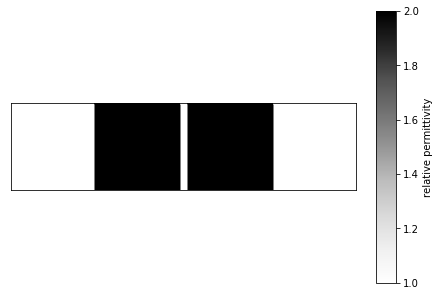

In [6]:
# define permittivity of three port system
eps_r, design_region = accelerator(beta, gap, lambda0, L, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)

# make a new simulation
simulation = Simulation(omega,eps_r,dl,NPML,pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl)))

simulation.plt_eps(tiled_y=num_cells)
plt.show()

In [7]:
# set the plane wave source
simulation = Simulation(omega, eps_r, dl, NPML, 'Hz')
simulation.src = np.zeros((Nx, Ny))
simulation.src[NPML[0] + int(spc/dl), :] = 1e-9

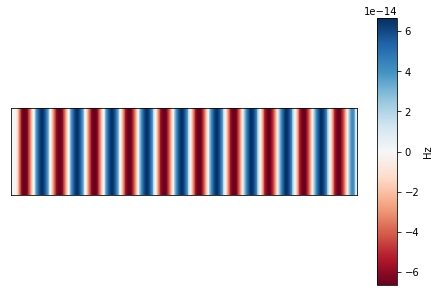

E0 = 2.5075887290727583e-11


In [8]:
# make an empty space simulation for normalization of fields
eps_normalize, _ = accelerator(beta, gap, lambda0, L, spc, dl, NPML, 1)
sim_normalize = Simulation(omega,eps_normalize,dl,NPML,pol)
sim_normalize.src = np.zeros((Nx, Ny))
sim_normalize.src[NPML[0] + int(spc/dl), :] = 1e-9

(_,Ey,Hz) = sim_normalize.solve_fields()
sim_normalize.plt_re(tiled_y=num_cells, outline=False)
plt.show()
E0 = np.mean(np.abs(Ey[nx, :]))
print('E0 = {}'.format(E0))

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


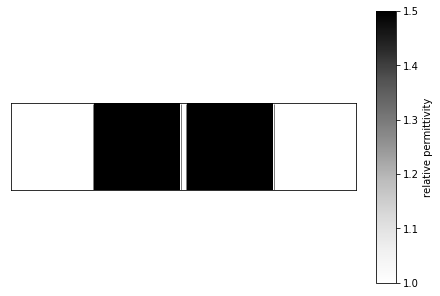

In [9]:
# initalize the design region randomly
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps(tiled_y=num_cells)
plt.show()

In [10]:
# define objective function  (equal power transmission to bottom and top)
from angler.objective import Objective, obj_arg
arg1 = obj_arg('ey', component='Ey', nl=False)

import autograd.numpy as npa
def J(ey):
    eta = npa.zeros((Nx, Ny), dtype=npa.complex128)
    eta[nx, :] = 1/Ny*npa.exp(1j*2*npa.pi*dl*npa.linspace(0, Ny-1, Ny)/beta/lambda0)
    return npa.sum(npa.real(ey*eta)) / E0

objective = Objective(J, arg_list=[arg1])

In [11]:
# make optimization object and check derivatives
R = None
beta_proj = 1e-9
eta= 0.5
optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta_proj, eta=eta)

In [12]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-6)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-2.423866190165091e-07, -1.4206992835103626e-10, 9.391719415248798e-14, -0.00015263338647289627, -2.280599835878484e-11]
numerical gradient = [-4.173511475224865e-07, -2.190549108611649e-10, -1.0952745543058248e-10, -0.00022393797984941806, -1.4174141291016552e-10]


In [13]:
# run the optimization
optimization.run(method='lbfgs', Nsteps=1000, step_size=2e-1)

 ObjectiveFn:  0.455 Iteration:  998/1000 ETA:   0:00:00                       

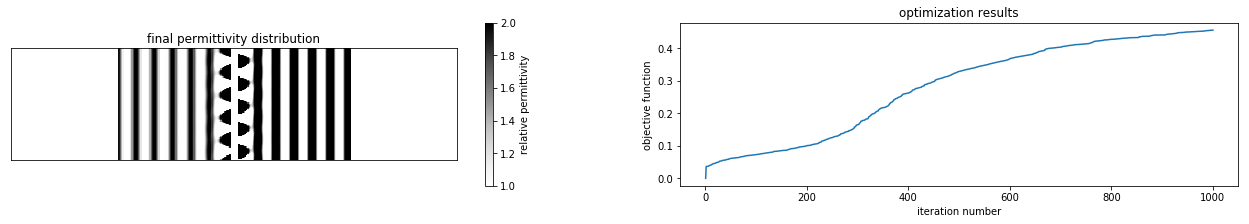

In [14]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,3))

simulation.plt_eps(ax=ax1, tiled_y=num_cells, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


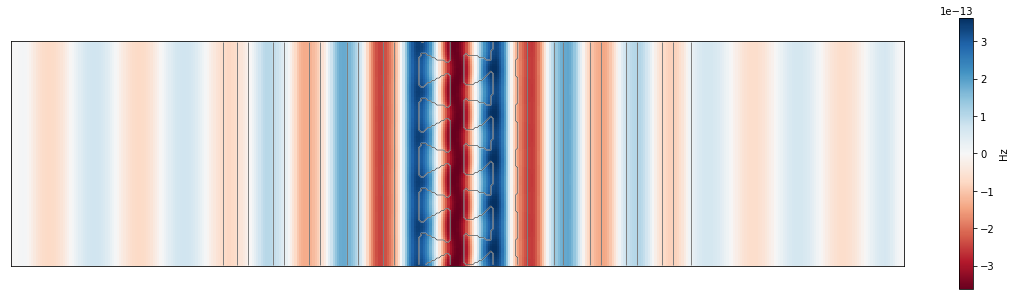

In [15]:
# setup subplots
f, (ax) = plt.subplots(1,1, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_re(ax=ax, tiled_y=num_cells)
ax1.set_title('linear field')

plt.show()

for more info see

**Hughes, Tyler, et al. "Method for computationally efficient design of dielectric laser accelerator structures." Optics Express 25.13 (2017): 15414-15427**